## Part 1: Preprocessing Data

In [1]:
import pandas as pd

path = 'C:/Users/2093/Desktop/Data Center/03. Data/06. companies/財政部廠商進出口資料/KMG_HS6COUNTRY.csv'
df = pd.read_csv(path, names=['ban', 'code', 'country', 'year', 'month', 'ex', 'im'], header=0,
                 dtype={'ban': str, 'code': str, 'country': str, 'year': str, 'month': str,
                        'ex': int, 'im': int})
# Remove yearly total rows
df = df[df['month'].notnull()]
# Pad zeros and construct DatetimeIndex
df['month'] = df['month'].apply(lambda x: x.zfill(2))
df.index = pd.to_datetime(df['year'] + df['month'], format='%Y%m')
df.index.name = 'date'
# Drop original year and month columns
df = df.drop(['year', 'month'], axis=1)

## Part 2: Export Commodity Summary Statistics

In [2]:
import numpy as np

n_codes = np.mean([len(df.loc['2014', :]['code'].unique()), len(df.loc['2015', :]['code'].unique())])
print('臺灣一年平均進出口{:,.0f}種HS6產品。'.format(n_codes))

臺灣一年平均進出口5,262種HS6產品。


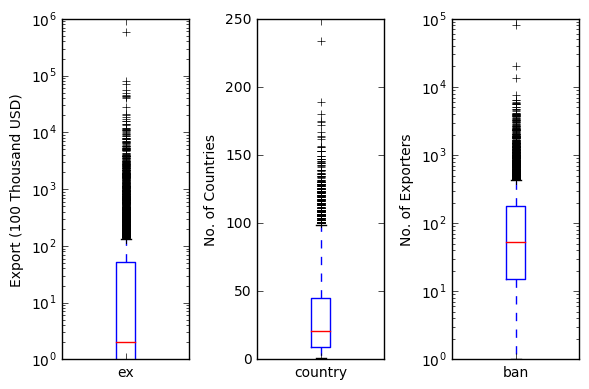

count      5246.000000
mean        440.575677
std        8587.281250
min           0.000000
25%           0.000000
50%           2.000000
75%          53.000000
max      594553.000000
Name: ex, dtype: float64

單一產品之出口額中位數為20萬美元，平均值則達4,406萬美元，二者落差極大，顯示離群值有非常大的影響力。
其中金額最大者為854239(積體電路)。

count    5246.000000
mean       31.627716
std        31.341089
min         1.000000
25%         9.000000
50%        21.000000
75%        45.000000
max       234.000000
Name: country, dtype: float64

平均每種產品出口至32個國家。
除了989900(旅客攜帶之應稅零星物品)外，出口至最多國家(189國)的產品是392690(其他塑膠製品)。

count     5246.000000
mean       233.629623
std       1275.404845
min          1.000000
25%         15.000000
50%         53.000000
75%        179.750000
max      81391.000000
Name: ban, dtype: float64

以中位數而言，每種產品有53家不重複的出口商。
扣除989900(旅客攜帶之應稅零星物品)，最多出口商的產品為392690(其他塑膠製品)，出口商達20,061家。


In [3]:
import matplotlib.pyplot as plt

code_stats = df.loc['2015', :].groupby(['code']).agg({'ex': 'sum', 'country': 'nunique', 'ban': 'nunique'})

plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=3)
code_stats['ex'].plot(ax=axes[0], kind='box')
code_stats['country'].plot(ax=axes[1], kind='box')
code_stats['ban'].plot(ax=axes[2], kind='box')
axes[0].set_yscale('log')
axes[0].set_ylabel('Export (100 Thousand USD)')
axes[1].set_ylabel('No. of Countries')
axes[2].set_yscale('log')
axes[2].set_ylabel('No. of Exporters')
plt.tight_layout()
plt.show()

print(code_stats['ex'].describe())
print('\n單一產品之出口額中位數為{:.0f}萬美元，平均值則達{:,.0f}萬美元，二者落差極大，顯示離群值有非常大的影響力。\n'.format(
    code_stats['ex'].describe()['50%'] * 10, code_stats['ex'].describe()['mean'] * 10) +
    '其中金額最大者為{}(積體電路)。\n'.format(code_stats[code_stats['ex'] == code_stats['ex'].max()].index[0]))

print(code_stats['country'].describe())
print('\n平均每種產品出口至{:.0f}個國家。\n'.format(code_stats['country'].describe()['mean']) +
     '除了{}(旅客攜帶之應稅零星物品)外，出口至最多國家({}國)的產品是{}(其他塑膠製品)。\n'.format(
        code_stats[code_stats['country'] == code_stats['country'].max()].index[0],
        code_stats.sort_values(by='country', ascending=False)['country'][1],
        code_stats.sort_values(by='country', ascending=False).index[1]))

print(code_stats['ban'].describe())
print('\n以中位數而言，每種產品有{:.0f}家不重複的出口商。\n'.format(code_stats['ban'].describe()['50%']) +
    '扣除{}(旅客攜帶之應稅零星物品)，最多出口商的產品為{}(其他塑膠製品)，出口商達{:,}家。'.format(
        code_stats[code_stats['ban'] == code_stats['ban'].max()].index[0],
        code_stats.sort_values(by='ban', ascending=False).index[1],
        code_stats.sort_values(by='ban', ascending=False)['ban'][1]))

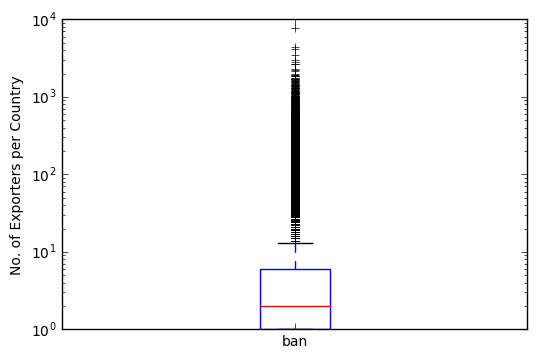

                 ban
count  165685.000000
mean       11.595666
std        57.372399
min         1.000000
25%         1.000000
50%         2.000000
75%         6.000000
max      7802.000000

若是同時考慮自臺灣進口的國家別，則每種產品在每個國家約只有1至6家臺灣出口商。
其中最多臺灣出口商的組合為392690(其他塑膠製品)-CN(中國)，共7,802家。


In [4]:
code_stats_country = df.loc['2015', :].groupby(['code', 'country']).agg({'ban': 'nunique'}).drop(
    '989900', level='code')

plt.clf()
code_stats_country.plot(kind='box', logy=True)
plt.ylabel('No. of Exporters per Country')
plt.show()

print(code_stats_country.describe())
print('\n若是同時考慮自臺灣進口的國家別，則每種產品在每個國家約只有{:.0f}至{:.0f}家臺灣出口商。\n'.format(
    code_stats_country['ban'].describe()['25%'], code_stats_country['ban'].describe()['75%']) +
    '其中最多臺灣出口商的組合為{}(其他塑膠製品)-{}(中國)，共{:,.0f}家。'.format(
    code_stats_country[code_stats_country['ban'] == code_stats_country['ban'].max()].index[0][0],
    code_stats_country[code_stats_country['ban'] == code_stats_country['ban'].max()].index[0][1],
    code_stats_country['ban'].describe()['max']))

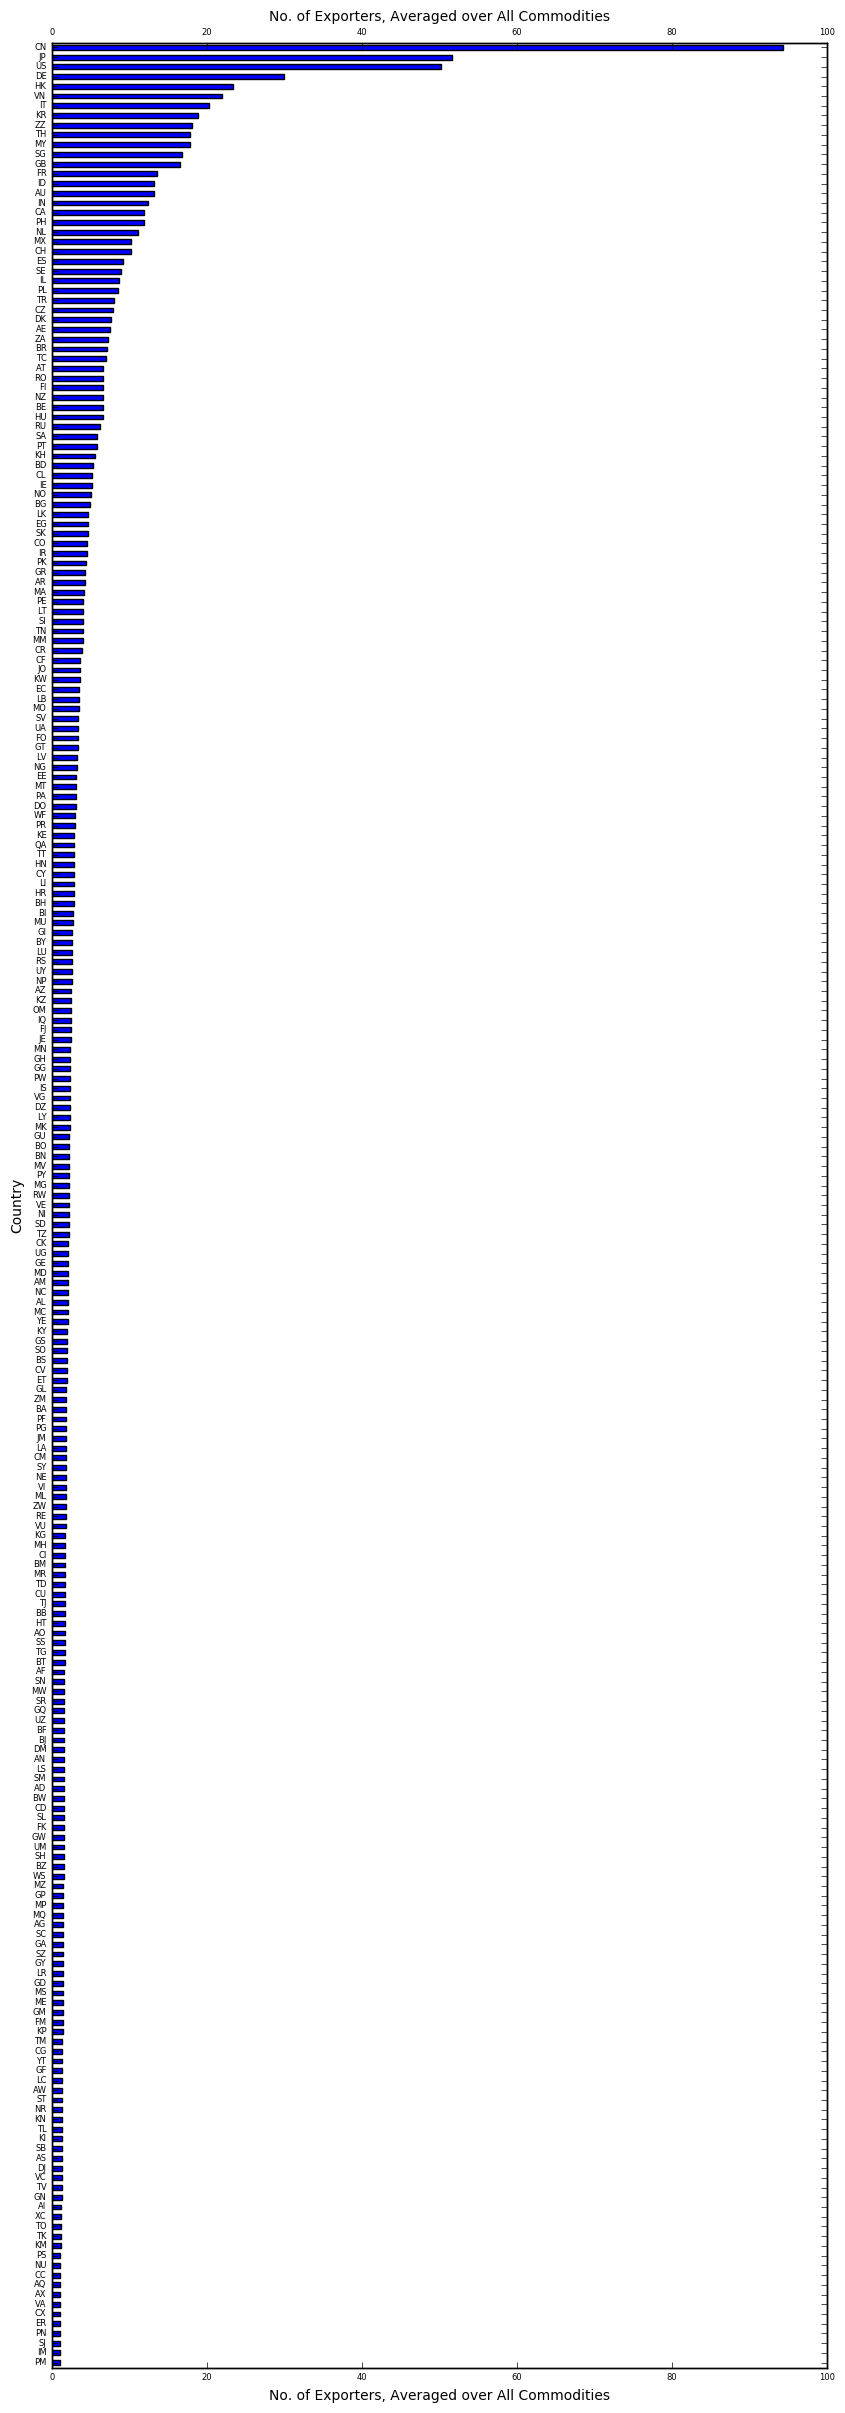

In [5]:
plt.clf()
code_stats_avg = df.loc['2015', :].groupby(['code', 'country']).agg({'ban': 'nunique'}).groupby(
    level='country').agg({'ban': 'mean'}).sort_values(by='ban')
ax1 = code_stats_avg.plot(kind='barh', fontsize=6, figsize=(10, 30), legend=None)
plt.xlabel('No. of Exporters, Averaged over All Commodities') 
plt.ylabel('Country')

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.tick_params(labelsize=6)
ax2.set_xlabel('No. of Exporters, Averaged over All Commodities')
plt.show()

In [6]:
print('由上圖可看到，不同國家的每項產品平均出口商家數差異相當大。平均出口商家數最多的國家(地區)為：\n\n' +
      '國家(地區)\t出口商家數\n{}\t\t{:.0f}\n{}\t\t{:.0f}\n{}\t\t{:.0f}\n{}\t\t{:.0f}\n{}\t\t{:.0f}'.format(
    code_stats_avg.sort_values(by='ban', ascending=False).index[0],
    code_stats_avg.sort_values(by='ban', ascending=False)['ban'][0],
    code_stats_avg.sort_values(by='ban', ascending=False).index[1],
    code_stats_avg.sort_values(by='ban', ascending=False)['ban'][1],
    code_stats_avg.sort_values(by='ban', ascending=False).index[2],
    code_stats_avg.sort_values(by='ban', ascending=False)['ban'][2],
    code_stats_avg.sort_values(by='ban', ascending=False).index[3],
    code_stats_avg.sort_values(by='ban', ascending=False)['ban'][3],
    code_stats_avg.sort_values(by='ban', ascending=False).index[4],
    code_stats_avg.sort_values(by='ban', ascending=False)['ban'][4]
    ))

由上圖可看到，不同國家的每項產品平均出口商家數差異相當大。平均出口商家數最多的國家(地區)為：

國家(地區)	出口商家數
CN		94
JP		52
US		50
DE		30
HK		23
